# DMD Neural Operator

In [1]:
pip install pydmd tqdm torchviz

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from pydmd import DMD
from tqdm import tqdm
from typing import Dict
from torchviz import make_dot

In [3]:
class DMDProcessor:
    def __init__(self, data: torch.Tensor, rank: int):
        """Process input data using Dynamic Mode Decomposition.

        Args:
            data: Input tensor of shape (batch_size, ny, nx)
            rank: Rank for SVD approximation
        """
        self.data = data
        self.rank = rank

    def _validate_input(self):
        if self.rank <= 0:
            raise ValueError("Rank must be positive integer")

    def _compute_dmd(self):
        """Perform DMD and return reconstructed data."""
        try:
            snapshots = self.data.reshape(self.data.shape[0], -1).T
            dmd = DMD(svd_rank=self.rank)
            dmd.fit(snapshots)

            if dmd.reconstructed_data is None:
                raise RuntimeError("DMD reconstruction failed")

            return dmd

        except Exception as e:
            raise RuntimeError(f"DMD processing failed: {str(e)}")

    def _calc_energy(self):
        dmd = self._compute_dmd()
        energy = np.cumsum(np.abs(dmd.amplitudes)) / np.sum(np.abs(dmd.amplitudes))
        n_modes = np.argmax(energy > 0.95) + 1
        return n_modes

    def method(self):
        dmd = self._compute_dmd()

        modes = [dmd.modes.real[:, i] for i in range(len(dmd.amplitudes))]
        dynamics = [dmd.dynamics.real[i] for i in range(len(dmd.amplitudes))]
        return [modes, dynamics]

In [4]:
class DMDNeuralOperator(nn.Module):
  def __init__(self, branch1_dim, branch_dmd_dim_modes, branch_dmd_dim_dynamics, trunk_dim):
      """Neural operator with DMD preprocessing.

      Args:
          branch1_dim: Layer dimensions for primary branch
          branch_dmd_dim_modes: Layer dimensions for DMD modes branch
          branch_dmd_dim_dynamics: Layer dimensions for DMD dynamics branch
          trunk_dims: Layer dimensions for trunk network
      """
      super(DMDNeuralOperator, self).__init__()

      modules = []
      for i, h_dim in enumerate(branch1_dim):
        if i == 0:
          in_channels = h_dim
        else:
          modules.append(nn.Sequential(
              nn.Linear(in_channels, h_dim),
              nn.Tanh()
              )
          )
          in_channels = h_dim

      self._branch_1 = nn.Sequential(*modules)

      modules = []
      for i, h_dim in enumerate(branch_dmd_dim_modes):
        if i == 0:
          in_channels = h_dim
        else:
          modules.append(nn.Sequential(
              nn.Linear(in_channels, h_dim),
              nn.Tanh()
              )
          )
          in_channels = h_dim
      self._branch_dmd_modes = nn.Sequential(*modules)

      modules = []
      for i, h_dim in enumerate(branch_dmd_dim_dynamics):
        if i == 0:
          in_channels = h_dim
        else:
          modules.append(nn.Sequential(
              nn.Linear(in_channels, h_dim),
              nn.Tanh()
              )
          )
          in_channels = h_dim
      self._branch_dmd_dynamics = nn.Sequential(*modules)

      modules = []
      for i, h_dim in enumerate(trunk_dim):
        if i == 0:
          in_channels = h_dim
        else:
          modules.append(nn.Sequential(
              nn.Linear(in_channels, h_dim),
              nn.Tanh()
              )
          )
          in_channels = h_dim

      self._trunk = nn.Sequential(*modules)

      self.final_linear = nn.Linear(trunk_dim[-1], 10)

  def forward(self, f: torch.Tensor, f_dmd_modes: torch.Tensor, f_dmd_dynamics: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
    """Forward pass.

    Args:
        f: Input function (batch_size, *spatial_dims)
        x: Evaluation points (num_points, coord_dim)

    Returns:
        Output tensor (batch_size, num_points)
    """
    modes, dynamics = f_dmd_modes, f_dmd_dynamics

    branch_dmd_modes = self._branch_dmd_modes(modes)
    branch_dmd_dynamics = self._branch_dmd_dynamics(dynamics)
    y_branch_dmd = branch_dmd_modes * branch_dmd_dynamics

    y_branch1 = self._branch_1(f)
    y_br = y_branch1 * y_branch_dmd

    y_tr = self._trunk(x)

    y_out = y_br @ y_tr

    linear_out = nn.Linear(y_out.shape[-1], 10)
    tanh_out = nn.Tanh()

    y_out = self.final_linear(y_out)

    return y_out

  def loss(self, f, f_dmd_modes, f_dmd_dynamics, x, y):
    y_out = self.forward(f, f_dmd_modes, f_dmd_dynamics, x)
    loss = ((y_out - y) ** 2).mean()
    return loss

# Tests

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
class DMDNeuralOperatorDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame):
        self.data = dataframe

        self.init_states = list(dataframe['init_state'].values)
        self.end_states = list(dataframe['end_state'].values)
        self.modes = list(dataframe['modes'].values)
        self.dynamics = list(dataframe['dynamics'].values)

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        sample = {
            'init_state': torch.tensor(self.init_states[idx], dtype=torch.float32),
            'end_state': torch.tensor(self.end_states[idx], dtype=torch.float32),
            'modes': torch.tensor(self.modes[idx], dtype=torch.float32),
            'dynamics': torch.tensor(self.dynamics[idx], dtype=torch.float32)
        }
        return sample

In [7]:
def custom_collate_fn(batch: Dict[str, torch.Tensor]) -> Dict[str, torch.Tensor]:
    collated_batch = {}
    for key in batch[0].keys():
        try:
            collated_batch[key] = torch.stack([item[key] for item in batch])
        except RuntimeError:
            collated_batch[key] = [item[key] for item in batch]
    return collated_batch

In [8]:
def train_model(model, dataloader, val_dataset, epochs=100, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    criterion = nn.MSELoss()

    epochs_data = []
    train_losses = []
    test_losses = []

    best_loss = float('inf')

    for epoch in range(epochs):
        epoch_loss = 0
        model.train()

        for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
            f = batch['init_state']
            y = batch['end_state']
            modes = batch['modes']
            dynamics = batch['dynamics']

            xx = torch.linspace(0, 10, 10)
            yy = torch.linspace(0, 10, 10)
            grid_x, grid_y = torch.meshgrid(xx, yy, indexing='ij')
            grid = np.vstack(list(zip(grid_x.ravel(), grid_y.ravel())))
            grid = torch.Tensor(grid)

            optimizer.zero_grad()
            loss = model.loss(f, modes, dynamics, grid, y)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dataloader)
        train_losses.append(avg_loss)
        scheduler.step(avg_loss)

        model.eval()
        with torch.no_grad():
            batch_test = val_dataset[np.random.randint(0, len(val_dataset))]

            f_test = batch_test['init_state']
            y_test = batch_test['end_state']
            modes_test = batch_test['modes']
            dynamics_test = batch_test['dynamics']

            xx = torch.linspace(0, 10, 10)
            yy = torch.linspace(0, 10, 10)
            grid_x, grid_y = torch.meshgrid(xx, yy, indexing='ij')
            grid = np.vstack(list(zip(grid_x.ravel(), grid_y.ravel())))
            grid = torch.Tensor(grid)

            pred = model(f_test, modes_test, dynamics_test, grid)
            test_loss = criterion(pred, y_test)
            test_losses.append(test_loss.item())

        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), "best_dmd_neural_operator.pth")

        if epoch % 10 == 0:
            epochs_data.append(epoch)
        print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}, LR: {optimizer.param_groups[0]['lr']:.2e}")

    train_losses_dataframe = pd.DataFrame({"Epoch": epochs_data, "Loss": [train_losses[i] for i in range(len(train_losses)) if i % 10 == 0]})
    test_losses_dataframe = pd.DataFrame({"Epoch": epochs_data, "Loss": [test_losses[i] for i in range(len(test_losses)) if i % 10 == 0]})

    return train_losses, test_losses, train_losses_dataframe, test_losses_dataframe

In [9]:
def visualize_results_discrete(model, dataset, num_examples=3):
    model.eval()

    fig, axes = plt.subplots(num_examples, 4, figsize=(15, 5*num_examples))
    if num_examples == 1:
        axes = axes[np.newaxis, :]

    for i in range(num_examples):
        batch = dataset[i]

        f = batch['init_state']
        u = batch['end_state']
        modes = batch['modes']
        dynamics = batch['dynamics']

        xx = torch.linspace(0, 10, 10)
        yy = torch.linspace(0, 10, 10)
        grid_x, grid_y = torch.meshgrid(xx, yy, indexing='ij')
        grid = np.vstack(list(zip(grid_x.ravel(), grid_y.ravel())))
        grid = torch.Tensor(grid)

        with torch.no_grad():
            pred = model(f, modes, dynamics, grid)
            pred = pred.reshape(u.shape).numpy()

        true_final = u.numpy()
        pred_final = pred

        im = axes[i, 0].imshow(f.numpy(), cmap='hot')
        axes[i, 0].set_title(f"Пример {i+1}: Initial Condition")
        plt.colorbar(im, ax=axes[i, 0])

        im = axes[i, 1].imshow(true_final, cmap='hot')
        axes[i, 1].set_title("True Solution")
        plt.colorbar(im, ax=axes[i, 1])

        im = axes[i, 2].imshow(pred_final, cmap='hot')
        axes[i, 2].set_title("Predicted Solution")
        plt.colorbar(im, ax=axes[i, 2])

        error = np.abs(pred_final - true_final)
        im = axes[i, 3].imshow(error, cmap='hot')
        axes[i, 3].set_title("Absolute Error")
        plt.colorbar(im, ax=axes[i, 3])

    plt.tight_layout()
    plt.savefig("dmd_neural_operator_discrete_results.png")
    plt.show()

In [10]:
def visualize_results_smooth(model, dataset, num_examples=3):
    model.eval()

    for i in range(num_examples):
        batch = dataset[i]

        f = batch['init_state']
        u = batch['end_state']
        modes = batch['modes']
        dynamics = batch['dynamics']

        xx = np.linspace(0, 10, 10)
        yy = np.linspace(0, 10, 10)
        grid_x, grid_y = np.meshgrid(xx, yy, indexing='ij')
        grid = np.vstack(list(zip(grid_x.ravel(), grid_y.ravel())))
        grid = torch.Tensor(grid)

        with torch.no_grad():
            pred = model(f, modes, dynamics, grid)
            pred = pred.reshape(len(xx), len(yy)).numpy()

        true_sol = u.numpy()
        pred_sol = pred

        fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(23, 5))

        im0 = ax0.pcolormesh(xx, yy, f.numpy(), shading='gouraud')
        ax0.set_title('Initial Condition')
        fig.colorbar(im0, ax=ax0)

        im1 = ax1.pcolormesh(xx, yy, true_sol, shading='gouraud')
        ax1.set_title('True Solution')
        fig.colorbar(im1, ax=ax1)

        im2 = ax2.pcolormesh(xx, yy, pred_sol, shading='gouraud')
        ax2.set_title('Predicted Solution')
        fig.colorbar(im2, ax=ax2)

        error = np.abs(true_sol - pred_sol)
        im3 = ax3.pcolormesh(xx, yy, error, shading='gouraud')
        ax3.set_title('Absolute Error')
        fig.colorbar(im3, ax=ax3)

        plt.tight_layout()
        plt.show()

    plt.savefig("dmd_neural_operator_smooth_results.png")
    plt.close()

In [11]:
def vis_net(model, val_dataset):
      batch = val_dataset[i]

      f = batch['init_state']
      u = batch['end_state']
      modes = batch['modes']
      dynamics = batch['dynamics']

      xx = np.linspace(0, 10, 10)
      yy = np.linspace(0, 10, 10)
      grid_x, grid_y = np.meshgrid(xx, yy, indexing='ij')
      grid = np.vstack(list(zip(grid_x.ravel(), grid_y.ravel())))
      grid = torch.Tensor(grid)

      pred = model(f, modes, dynamics, grid)
      make_dot(pred, params=dict(list(model.named_parameters()))).render("model_architecture", format="png")

## Heat Equation

In [14]:
class HeatEquationDataset(Dataset):
    def __init__(self, num_samples=1000, spatial_size=20, temporal_size=50, alpha=0.5, random_seed=None):
        self.num_samples = num_samples
        self.nx = self.ny = spatial_size
        self.temporal_size = temporal_size
        self.alpha = alpha
        self.random_seed = random_seed

        if random_seed is not None:
            np.random.seed(random_seed)

        self.data = self._generate_data()

    def _initialize_conditions(self):
        u0 = np.ones((self.ny, self.nx)) * 10

        corners = [(0, 0), (0, self.ny-1), (self.nx-1, 0), (self.nx-1, self.ny-1)]
        for (i, j) in corners:
            u0[j, i] = np.random.uniform(-25, 25)

        u0[:, 0] = np.linspace(u0[0, 0], u0[-1, 0], self.ny)
        u0[:, -1] = np.linspace(u0[0, -1], u0[-1, -1], self.ny)
        u0[0, :] = np.linspace(u0[0, 0], u0[0, -1], self.nx)
        u0[-1, :] = np.linspace(u0[-1, 0], u0[-1, -1], self.nx)

        return u0

    def _solve_heat(self, alpha):
        u0 = self._initialize_conditions()
        u = np.zeros((self.temporal_size, self.ny, self.nx))
        u[0] = u0

        dx = 1.0 / (self.nx - 1)
        dy = 1.0 / (self.ny - 1)
        dt = 0.001

        for t in range(1, self.temporal_size):
            u_prev = u[t-1]
            u_next = u_prev.copy()

            u_next[1:-1, 1:-1] = u_prev[1:-1, 1:-1] + alpha * dt / dx**2 * (
                u_prev[2:, 1:-1] - 2*u_prev[1:-1, 1:-1] + u_prev[:-2, 1:-1]
            ) + alpha * dt / dy**2 * (
                u_prev[1:-1, 2:] - 2*u_prev[1:-1, 1:-1] + u_prev[1:-1, :-2]
            )

            u_next[:, 0] = u0[:, 0]
            u_next[:, -1] = u0[:, -1]
            u_next[0, :] = u0[0, :]
            u_next[-1, :] = u0[-1, :]

            u[t] = u_next

        return u

    def _generate_data(self):
        dataset = []

        for _ in range(self.num_samples):
            sol = self._solve_heat(self.alpha)

            dmd_sol = DMDProcessor(sol, 10).method()

            dataset.append([[sol[0], sol[-1]], dmd_sol])

        return dataset

In [ ]:
def main_discrete():
    batch_size = 32
    epochs = 100
    rank = 10
    spatial_size = 10

    print("Data generation...")
    dataset = HeatEquationDataset(num_samples=1000, spatial_size=spatial_size).data
    dataframe = {"init_state": [i[0][0] for i in dataset],
                 "end_state": [i[0][1] for i in dataset],
                 "modes": [i[1][0] for i in dataset],
                 "dynamics": [i[1][1] for i in dataset]}

    dataframe = pd.DataFrame(dataframe)
    dataset = DMDNeuralOperatorDataset(dataframe)

    print("Data preparation...")
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    print("Model initialization...")
    branch1_dim = [spatial_size, 100, 100]
    branch_dmd_dim_modes = [100, 100, 100]
    branch_dmd_dim_dynamics = [50, 100, 100]
    trunk_dim = [2, 100, 100]

    print("Model training...")
    model = DMDNeuralOperator(branch1_dim, branch_dmd_dim_modes, branch_dmd_dim_dynamics, trunk_dim)

    train_losses, test_losses, train_losses_dataframe, test_losses_dataframe = train_model(model, train_loader, val_dataset, epochs=epochs)

    print("Visualization of results...")
    visualize_results_discrete(model, val_dataset, num_examples=3)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.ylim(0.0, 2.0)
    plt.grid()
    plt.savefig("heat_eq_discrete_model_learning_loss.png")
    plt.show()

    return train_losses_dataframe, test_losses_dataframe

In [ ]:
def main_smooth():
    batch_size = 32
    epochs = 100
    rank = 10
    spatial_size = 10

    print("Data generation...")
    dataset = HeatEquationDataset(num_samples=1000, spatial_size=spatial_size).data
    dataframe = {"init_state": [i[0][0] for i in dataset],
                 "end_state": [i[0][1] for i in dataset],
                 "modes": [i[1][0] for i in dataset],
                 "dynamics": [i[1][1] for i in dataset]}

    dataframe = pd.DataFrame(dataframe)
    dataset = DMDNeuralOperatorDataset(dataframe)

    print("Data preparation...")
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn)

    print("Model initialization...")
    branch1_dim = [spatial_size, 100, 100]
    branch_dmd_dim_modes = [100, 100, 100]
    branch_dmd_dim_dynamics = [50, 100, 100]
    trunk_dim = [2, 100, 100]

    print("Model training...")
    model = DMDNeuralOperator(branch1_dim, branch_dmd_dim_modes, branch_dmd_dim_dynamics, trunk_dim)

    train_losses, test_losses, train_losses_dataframe, test_losses_dataframe = train_model(model, train_loader, val_dataset, epochs=epochs)

    print("Visualization of results...")
    visualize_results_smooth(model, val_dataset, num_examples=3)

    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Learning Curves")
    plt.legend()
    plt.ylim(0.0, 2.0)
    plt.grid()
    plt.savefig("heat_eq_smooth_model_learning_loss.png")
    plt.show()

    return train_losses_dataframe, test_losses_dataframe

Data generation...
Data preparation...
Model initialization...
Model training...


Epoch 1/100: 100%|██████████| 25/25 [00:00<00:00, 45.31it/s]


Epoch 1, Loss: 81.6153, LR: 1.00e-03


Epoch 2/100: 100%|██████████| 25/25 [00:00<00:00, 42.93it/s]


Epoch 2, Loss: 44.3600, LR: 1.00e-03


Epoch 3/100: 100%|██████████| 25/25 [00:00<00:00, 30.34it/s]


Epoch 3, Loss: 22.3084, LR: 1.00e-03


Epoch 4/100: 100%|██████████| 25/25 [00:00<00:00, 29.52it/s]


Epoch 4, Loss: 13.5140, LR: 1.00e-03


Epoch 5/100: 100%|██████████| 25/25 [00:00<00:00, 30.82it/s]


Epoch 5, Loss: 11.0797, LR: 1.00e-03


Epoch 6/100: 100%|██████████| 25/25 [00:00<00:00, 48.77it/s]


Epoch 6, Loss: 8.1923, LR: 1.00e-03


Epoch 7/100: 100%|██████████| 25/25 [00:00<00:00, 48.38it/s]


Epoch 7, Loss: 5.3604, LR: 1.00e-03


Epoch 8/100: 100%|██████████| 25/25 [00:00<00:00, 48.59it/s]


Epoch 8, Loss: 4.1701, LR: 1.00e-03


Epoch 9/100: 100%|██████████| 25/25 [00:00<00:00, 48.29it/s]


Epoch 9, Loss: 3.5261, LR: 1.00e-03


Epoch 10/100: 100%|██████████| 25/25 [00:00<00:00, 49.49it/s]


Epoch 10, Loss: 2.9716, LR: 1.00e-03


Epoch 11/100: 100%|██████████| 25/25 [00:00<00:00, 46.89it/s]


Epoch 11, Loss: 2.5789, LR: 1.00e-03


Epoch 12/100: 100%|██████████| 25/25 [00:00<00:00, 48.97it/s]


Epoch 12, Loss: 2.3325, LR: 1.00e-03


Epoch 13/100: 100%|██████████| 25/25 [00:00<00:00, 47.46it/s]


Epoch 13, Loss: 1.8814, LR: 1.00e-03


Epoch 14/100: 100%|██████████| 25/25 [00:00<00:00, 49.87it/s]


Epoch 14, Loss: 1.6435, LR: 1.00e-03


Epoch 15/100: 100%|██████████| 25/25 [00:00<00:00, 47.89it/s]


Epoch 15, Loss: 1.5069, LR: 1.00e-03


Epoch 16/100: 100%|██████████| 25/25 [00:00<00:00, 49.02it/s]


Epoch 16, Loss: 1.3834, LR: 1.00e-03


Epoch 17/100: 100%|██████████| 25/25 [00:00<00:00, 46.34it/s]


Epoch 17, Loss: 1.3418, LR: 1.00e-03


Epoch 18/100: 100%|██████████| 25/25 [00:00<00:00, 47.57it/s]


Epoch 18, Loss: 1.2520, LR: 1.00e-03


Epoch 19/100: 100%|██████████| 25/25 [00:00<00:00, 47.89it/s]


Epoch 19, Loss: 1.2631, LR: 1.00e-03


Epoch 20/100: 100%|██████████| 25/25 [00:00<00:00, 49.09it/s]


Epoch 20, Loss: 1.1018, LR: 1.00e-03


Epoch 21/100: 100%|██████████| 25/25 [00:00<00:00, 47.17it/s]


Epoch 21, Loss: 1.0385, LR: 1.00e-03


Epoch 22/100: 100%|██████████| 25/25 [00:00<00:00, 49.74it/s]


Epoch 22, Loss: 1.0391, LR: 1.00e-03


Epoch 23/100: 100%|██████████| 25/25 [00:00<00:00, 47.90it/s]


Epoch 23, Loss: 0.9568, LR: 1.00e-03


Epoch 24/100: 100%|██████████| 25/25 [00:00<00:00, 38.93it/s]


Epoch 24, Loss: 0.9439, LR: 1.00e-03


Epoch 25/100: 100%|██████████| 25/25 [00:00<00:00, 31.24it/s]


Epoch 25, Loss: 1.0366, LR: 1.00e-03


Epoch 26/100: 100%|██████████| 25/25 [00:00<00:00, 29.91it/s]


Epoch 26, Loss: 0.9592, LR: 1.00e-03


Epoch 27/100: 100%|██████████| 25/25 [00:00<00:00, 33.61it/s]


Epoch 27, Loss: 0.9439, LR: 1.00e-03


Epoch 28/100: 100%|██████████| 25/25 [00:00<00:00, 49.69it/s]


Epoch 28, Loss: 1.0098, LR: 1.00e-03


Epoch 29/100: 100%|██████████| 25/25 [00:00<00:00, 48.23it/s]


Epoch 29, Loss: 0.9003, LR: 1.00e-03


Epoch 30/100: 100%|██████████| 25/25 [00:00<00:00, 49.76it/s]


Epoch 30, Loss: 0.8157, LR: 1.00e-03


Epoch 31/100: 100%|██████████| 25/25 [00:00<00:00, 45.09it/s]


Epoch 31, Loss: 0.8771, LR: 1.00e-03


Epoch 32/100: 100%|██████████| 25/25 [00:00<00:00, 48.53it/s]


Epoch 32, Loss: 0.8901, LR: 1.00e-03


Epoch 33/100: 100%|██████████| 25/25 [00:00<00:00, 47.75it/s]


Epoch 33, Loss: 1.0041, LR: 1.00e-03


Epoch 34/100: 100%|██████████| 25/25 [00:00<00:00, 45.59it/s]


Epoch 34, Loss: 0.8260, LR: 1.00e-03


Epoch 35/100: 100%|██████████| 25/25 [00:00<00:00, 50.00it/s]


Epoch 35, Loss: 0.7519, LR: 1.00e-03


Epoch 36/100: 100%|██████████| 25/25 [00:00<00:00, 47.08it/s]


Epoch 36, Loss: 0.7730, LR: 1.00e-03


Epoch 37/100: 100%|██████████| 25/25 [00:00<00:00, 47.37it/s]


Epoch 37, Loss: 0.7727, LR: 1.00e-03


Epoch 38/100: 100%|██████████| 25/25 [00:00<00:00, 47.87it/s]


Epoch 38, Loss: 0.7683, LR: 1.00e-03


Epoch 39/100: 100%|██████████| 25/25 [00:00<00:00, 49.16it/s]


Epoch 39, Loss: 0.7827, LR: 1.00e-03


Epoch 40/100: 100%|██████████| 25/25 [00:00<00:00, 45.96it/s]


Epoch 40, Loss: 0.7029, LR: 1.00e-03


Epoch 41/100: 100%|██████████| 25/25 [00:00<00:00, 49.27it/s]


Epoch 41, Loss: 0.7382, LR: 1.00e-03


Epoch 42/100: 100%|██████████| 25/25 [00:00<00:00, 47.84it/s]


Epoch 42, Loss: 0.7205, LR: 1.00e-03


Epoch 43/100: 100%|██████████| 25/25 [00:00<00:00, 49.96it/s]


Epoch 43, Loss: 0.7383, LR: 1.00e-03


Epoch 44/100: 100%|██████████| 25/25 [00:00<00:00, 47.78it/s]


Epoch 44, Loss: 0.7630, LR: 1.00e-03


Epoch 45/100: 100%|██████████| 25/25 [00:00<00:00, 50.14it/s]


Epoch 45, Loss: 0.7270, LR: 1.00e-03


Epoch 46/100: 100%|██████████| 25/25 [00:00<00:00, 36.96it/s]


Epoch 46, Loss: 0.6881, LR: 1.00e-03


Epoch 47/100: 100%|██████████| 25/25 [00:00<00:00, 31.06it/s]


Epoch 47, Loss: 0.7033, LR: 1.00e-03


Epoch 48/100: 100%|██████████| 25/25 [00:00<00:00, 29.99it/s]


Epoch 48, Loss: 0.6589, LR: 1.00e-03


Epoch 49/100: 100%|██████████| 25/25 [00:00<00:00, 37.01it/s]


Epoch 49, Loss: 0.6459, LR: 1.00e-03


Epoch 50/100: 100%|██████████| 25/25 [00:00<00:00, 47.12it/s]


Epoch 50, Loss: 0.6918, LR: 1.00e-03


Epoch 51/100: 100%|██████████| 25/25 [00:00<00:00, 49.65it/s]


Epoch 51, Loss: 0.6770, LR: 1.00e-03


Epoch 52/100: 100%|██████████| 25/25 [00:00<00:00, 45.74it/s]


Epoch 52, Loss: 0.6149, LR: 1.00e-03


Epoch 53/100: 100%|██████████| 25/25 [00:00<00:00, 47.29it/s]


Epoch 53, Loss: 0.6218, LR: 1.00e-03


Epoch 54/100: 100%|██████████| 25/25 [00:00<00:00, 47.35it/s]


Epoch 54, Loss: 0.7235, LR: 1.00e-03


Epoch 55/100: 100%|██████████| 25/25 [00:00<00:00, 48.70it/s]


Epoch 55, Loss: 0.6627, LR: 1.00e-03


Epoch 56/100: 100%|██████████| 25/25 [00:00<00:00, 48.00it/s]


Epoch 56, Loss: 0.6608, LR: 1.00e-03


Epoch 57/100: 100%|██████████| 25/25 [00:00<00:00, 46.67it/s]


Epoch 57, Loss: 0.6733, LR: 1.00e-03


Epoch 58/100: 100%|██████████| 25/25 [00:00<00:00, 43.90it/s]


Epoch 58, Loss: 0.6104, LR: 1.00e-03


Epoch 59/100: 100%|██████████| 25/25 [00:00<00:00, 46.94it/s]


Epoch 59, Loss: 0.5814, LR: 1.00e-03


Epoch 60/100: 100%|██████████| 25/25 [00:00<00:00, 45.20it/s]


Epoch 60, Loss: 0.5701, LR: 1.00e-03


Epoch 61/100: 100%|██████████| 25/25 [00:00<00:00, 49.14it/s]


Epoch 61, Loss: 0.6375, LR: 1.00e-03


Epoch 62/100: 100%|██████████| 25/25 [00:00<00:00, 47.64it/s]


Epoch 62, Loss: 0.6220, LR: 1.00e-03


Epoch 63/100: 100%|██████████| 25/25 [00:00<00:00, 48.93it/s]


Epoch 63, Loss: 0.6232, LR: 1.00e-03


Epoch 64/100: 100%|██████████| 25/25 [00:00<00:00, 47.80it/s]


Epoch 64, Loss: 0.6211, LR: 1.00e-03


Epoch 65/100: 100%|██████████| 25/25 [00:00<00:00, 49.30it/s]


Epoch 65, Loss: 0.6388, LR: 1.00e-03


Epoch 66/100: 100%|██████████| 25/25 [00:00<00:00, 47.76it/s]


Epoch 66, Loss: 0.5736, LR: 5.00e-04


Epoch 67/100: 100%|██████████| 25/25 [00:00<00:00, 49.32it/s]


Epoch 67, Loss: 0.4939, LR: 5.00e-04


Epoch 68/100: 100%|██████████| 25/25 [00:00<00:00, 31.44it/s]


Epoch 68, Loss: 0.4855, LR: 5.00e-04


Epoch 69/100: 100%|██████████| 25/25 [00:00<00:00, 30.15it/s]


Epoch 69, Loss: 0.4861, LR: 5.00e-04


Epoch 70/100: 100%|██████████| 25/25 [00:00<00:00, 28.41it/s]


Epoch 70, Loss: 0.4902, LR: 5.00e-04


Epoch 71/100: 100%|██████████| 25/25 [00:00<00:00, 48.11it/s]


Epoch 71, Loss: 0.4785, LR: 5.00e-04


Epoch 72/100: 100%|██████████| 25/25 [00:00<00:00, 47.56it/s]


Epoch 72, Loss: 0.4673, LR: 5.00e-04


Epoch 73/100: 100%|██████████| 25/25 [00:00<00:00, 48.44it/s]


Epoch 73, Loss: 0.4837, LR: 5.00e-04


Epoch 74/100: 100%|██████████| 25/25 [00:00<00:00, 47.93it/s]


Epoch 74, Loss: 0.4719, LR: 5.00e-04


Epoch 75/100: 100%|██████████| 25/25 [00:00<00:00, 48.98it/s]


Epoch 75, Loss: 0.4699, LR: 5.00e-04


Epoch 76/100: 100%|██████████| 25/25 [00:00<00:00, 46.52it/s]


Epoch 76, Loss: 0.4773, LR: 5.00e-04


Epoch 77/100: 100%|██████████| 25/25 [00:00<00:00, 49.75it/s]


Epoch 77, Loss: 0.4589, LR: 5.00e-04


Epoch 78/100: 100%|██████████| 25/25 [00:00<00:00, 46.95it/s]


Epoch 78, Loss: 0.4617, LR: 5.00e-04


Epoch 79/100: 100%|██████████| 25/25 [00:00<00:00, 48.85it/s]


Epoch 79, Loss: 0.4726, LR: 5.00e-04


Epoch 80/100: 100%|██████████| 25/25 [00:00<00:00, 46.25it/s]


Epoch 80, Loss: 0.4444, LR: 5.00e-04


Epoch 81/100: 100%|██████████| 25/25 [00:00<00:00, 47.92it/s]


Epoch 81, Loss: 0.4896, LR: 5.00e-04


Epoch 82/100: 100%|██████████| 25/25 [00:00<00:00, 49.76it/s]


Epoch 82, Loss: 0.4838, LR: 5.00e-04


Epoch 83/100: 100%|██████████| 25/25 [00:00<00:00, 48.49it/s]


Epoch 83, Loss: 0.4601, LR: 5.00e-04


Epoch 84/100: 100%|██████████| 25/25 [00:00<00:00, 47.45it/s]


Epoch 84, Loss: 0.4716, LR: 5.00e-04


Epoch 85/100: 100%|██████████| 25/25 [00:00<00:00, 48.06it/s]


Epoch 85, Loss: 0.4608, LR: 5.00e-04


Epoch 86/100: 100%|██████████| 25/25 [00:00<00:00, 48.26it/s]


Epoch 86, Loss: 0.4470, LR: 2.50e-04


Epoch 87/100: 100%|██████████| 25/25 [00:00<00:00, 47.56it/s]


Epoch 87, Loss: 0.4252, LR: 2.50e-04


Epoch 88/100: 100%|██████████| 25/25 [00:00<00:00, 49.92it/s]


Epoch 88, Loss: 0.4213, LR: 2.50e-04


Epoch 89/100: 100%|██████████| 25/25 [00:00<00:00, 45.59it/s]


Epoch 89, Loss: 0.4188, LR: 2.50e-04


Epoch 90/100: 100%|██████████| 25/25 [00:00<00:00, 30.09it/s]


Epoch 90, Loss: 0.4096, LR: 2.50e-04


Epoch 91/100: 100%|██████████| 25/25 [00:00<00:00, 30.15it/s]


Epoch 91, Loss: 0.4083, LR: 2.50e-04


Epoch 92/100: 100%|██████████| 25/25 [00:00<00:00, 31.04it/s]


Epoch 92, Loss: 0.4124, LR: 2.50e-04


Epoch 93/100: 100%|██████████| 25/25 [00:00<00:00, 46.11it/s]


Epoch 93, Loss: 0.4184, LR: 2.50e-04


Epoch 94/100: 100%|██████████| 25/25 [00:00<00:00, 49.02it/s]


Epoch 94, Loss: 0.4100, LR: 2.50e-04


Epoch 95/100: 100%|██████████| 25/25 [00:00<00:00, 46.55it/s]


Epoch 95, Loss: 0.4120, LR: 2.50e-04


Epoch 96/100: 100%|██████████| 25/25 [00:00<00:00, 49.22it/s]


Epoch 96, Loss: 0.4107, LR: 2.50e-04


Epoch 97/100: 100%|██████████| 25/25 [00:00<00:00, 47.08it/s]


Epoch 97, Loss: 0.4095, LR: 1.25e-04


Epoch 98/100: 100%|██████████| 25/25 [00:00<00:00, 49.18it/s]


Epoch 98, Loss: 0.3933, LR: 1.25e-04


Epoch 99/100: 100%|██████████| 25/25 [00:00<00:00, 47.18it/s]


Epoch 99, Loss: 0.3959, LR: 1.25e-04


Epoch 100/100: 100%|██████████| 25/25 [00:00<00:00, 50.21it/s]


Epoch 100, Loss: 0.3922, LR: 1.25e-04
Visualization of results...


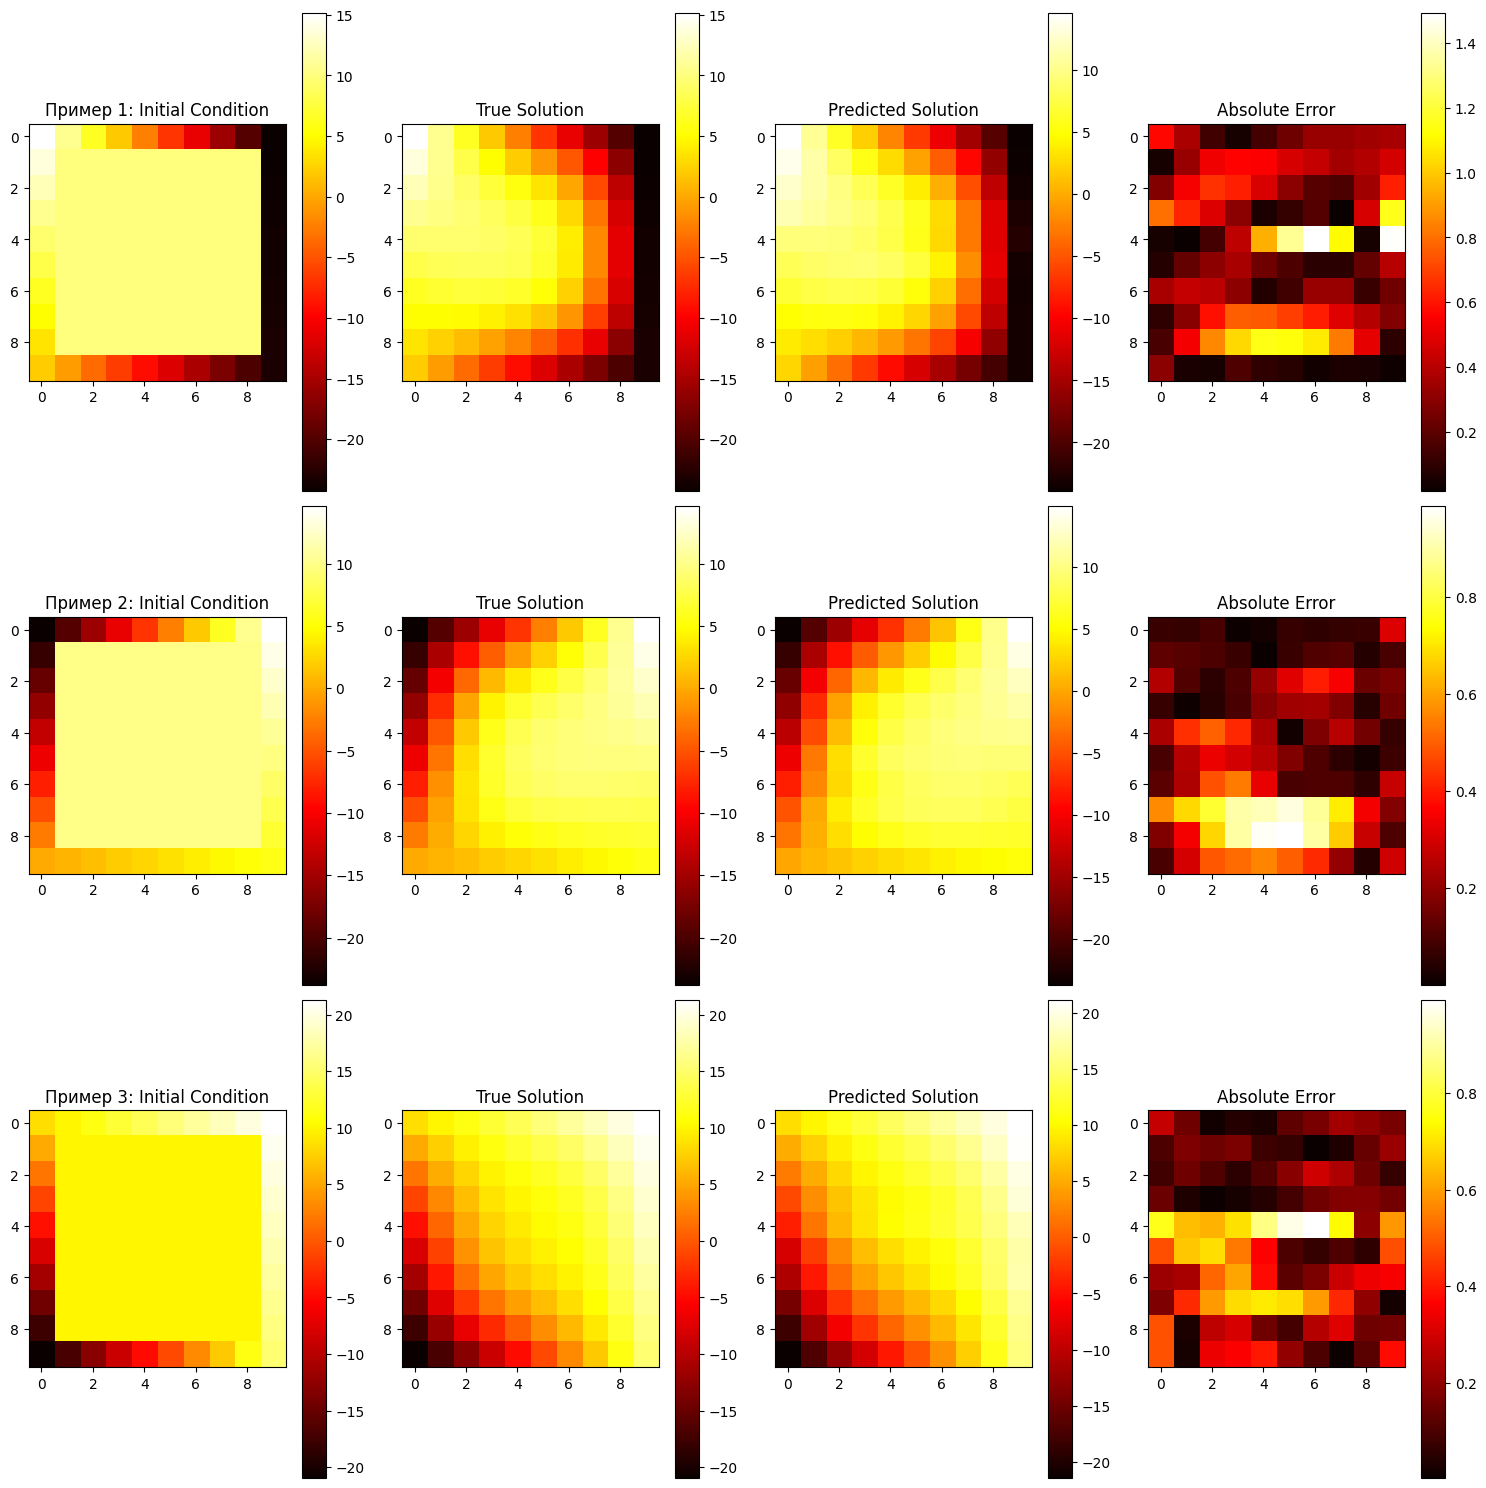

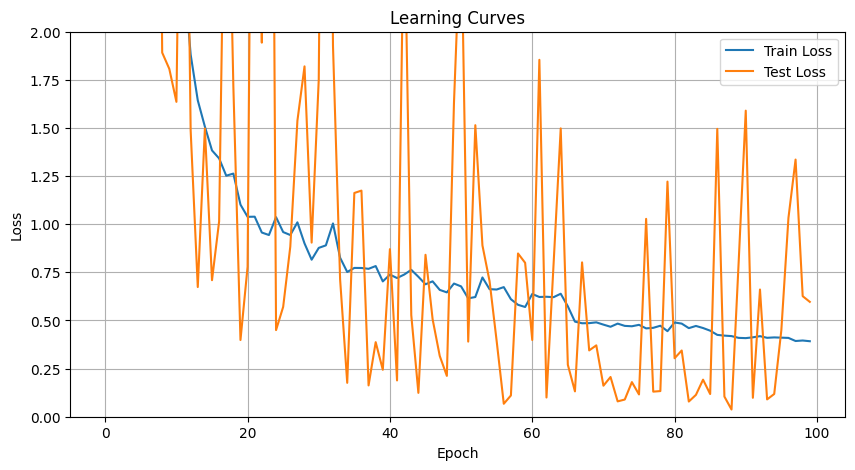

In [ ]:
train_losses_dataframe, test_losses_dataframe = main_discrete()

In [ ]:
train_losses_dataframe

,Epoch,Loss
0,0,81.615294
1,10,2.578904
2,20,1.038493
3,30,0.877064
4,40,0.738177
5,50,0.677031
6,60,0.637514
7,70,0.478463
8,80,0.489603
9,90,0.408306


In [ ]:
test_losses_dataframe

,Epoch,Loss
0,0,18.839275
1,10,1.635750
2,20,0.779013
3,30,1.751799
4,40,0.870436
5,50,2.595637
6,60,0.398561
7,70,0.161147
8,80,0.303753
9,90,1.589949


In [ ]:
print(train_losses_dataframe.to_latex(index=False,
                                      caption="Heat Equation Losses",
                                      position="htbp",
                                      column_format="|l|l|",
                                      escape=False,
                                      )
)

\begin{table}[htbp]
\caption{Heat Equation Losses}
\begin{tabular}{|l|l|}
\toprule
Epoch & Loss \\
\midrule
0 & 81.615294 \\
10 & 2.578904 \\
20 & 1.038493 \\
30 & 0.877064 \\
40 & 0.738177 \\
50 & 0.677031 \\
60 & 0.637514 \\
70 & 0.478463 \\
80 & 0.489603 \\
90 & 0.408306 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
print(test_losses_dataframe.to_latex(index=False,
                                     caption="Heat Equation Losses",
                                     position="htbp",
                                     column_format="|l|l|",
                                     escape=False,
                                      )
)

\begin{table}[htbp]
\caption{Heat Equation Losses}
\begin{tabular}{|l|l|}
\toprule
Epoch & Loss \\
\midrule
0 & 18.839275 \\
10 & 1.635750 \\
20 & 0.779013 \\
30 & 1.751799 \\
40 & 0.870436 \\
50 & 2.595637 \\
60 & 0.398561 \\
70 & 0.161147 \\
80 & 0.303753 \\
90 & 1.589949 \\
\bottomrule
\end{tabular}
\end{table}



Data generation...
Data preparation...
Model initialization...
Model training...


Epoch 1/100: 100%|██████████| 25/25 [00:00<00:00, 44.68it/s]


Epoch 1, Loss: 83.1916, LR: 1.00e-03


Epoch 2/100: 100%|██████████| 25/25 [00:00<00:00, 49.54it/s]


Epoch 2, Loss: 47.5328, LR: 1.00e-03


Epoch 3/100: 100%|██████████| 25/25 [00:00<00:00, 46.94it/s]


Epoch 3, Loss: 21.4100, LR: 1.00e-03


Epoch 4/100: 100%|██████████| 25/25 [00:00<00:00, 50.08it/s]


Epoch 4, Loss: 14.1827, LR: 1.00e-03


Epoch 5/100: 100%|██████████| 25/25 [00:00<00:00, 47.59it/s]


Epoch 5, Loss: 9.6749, LR: 1.00e-03


Epoch 6/100: 100%|██████████| 25/25 [00:00<00:00, 48.03it/s]


Epoch 6, Loss: 6.2069, LR: 1.00e-03


Epoch 7/100: 100%|██████████| 25/25 [00:00<00:00, 48.71it/s]


Epoch 7, Loss: 5.0193, LR: 1.00e-03


Epoch 8/100: 100%|██████████| 25/25 [00:00<00:00, 48.16it/s]


Epoch 8, Loss: 4.1087, LR: 1.00e-03


Epoch 9/100: 100%|██████████| 25/25 [00:00<00:00, 49.86it/s]


Epoch 9, Loss: 3.5160, LR: 1.00e-03


Epoch 10/100: 100%|██████████| 25/25 [00:00<00:00, 47.51it/s]


Epoch 10, Loss: 3.0132, LR: 1.00e-03


Epoch 11/100: 100%|██████████| 25/25 [00:00<00:00, 48.68it/s]


Epoch 11, Loss: 2.5367, LR: 1.00e-03


Epoch 12/100: 100%|██████████| 25/25 [00:00<00:00, 48.12it/s]


Epoch 12, Loss: 2.1936, LR: 1.00e-03


Epoch 13/100: 100%|██████████| 25/25 [00:00<00:00, 47.75it/s]


Epoch 13, Loss: 2.0482, LR: 1.00e-03


Epoch 14/100: 100%|██████████| 25/25 [00:00<00:00, 31.21it/s]


Epoch 14, Loss: 1.8287, LR: 1.00e-03


Epoch 15/100: 100%|██████████| 25/25 [00:00<00:00, 30.68it/s]


Epoch 15, Loss: 1.6260, LR: 1.00e-03


Epoch 16/100: 100%|██████████| 25/25 [00:00<00:00, 29.24it/s]


Epoch 16, Loss: 1.5779, LR: 1.00e-03


Epoch 17/100: 100%|██████████| 25/25 [00:00<00:00, 48.85it/s]


Epoch 17, Loss: 1.5557, LR: 1.00e-03


Epoch 18/100: 100%|██████████| 25/25 [00:00<00:00, 49.44it/s]


Epoch 18, Loss: 1.4020, LR: 1.00e-03


Epoch 19/100: 100%|██████████| 25/25 [00:00<00:00, 49.63it/s]


Epoch 19, Loss: 1.4267, LR: 1.00e-03


Epoch 20/100: 100%|██████████| 25/25 [00:00<00:00, 48.79it/s]


Epoch 20, Loss: 1.4226, LR: 1.00e-03


Epoch 21/100: 100%|██████████| 25/25 [00:00<00:00, 49.20it/s]


Epoch 21, Loss: 1.2448, LR: 1.00e-03


Epoch 22/100: 100%|██████████| 25/25 [00:00<00:00, 48.60it/s]


Epoch 22, Loss: 1.3154, LR: 1.00e-03


Epoch 23/100: 100%|██████████| 25/25 [00:00<00:00, 49.30it/s]


Epoch 23, Loss: 1.2344, LR: 1.00e-03


Epoch 24/100: 100%|██████████| 25/25 [00:00<00:00, 47.41it/s]


Epoch 24, Loss: 1.1679, LR: 1.00e-03


Epoch 25/100: 100%|██████████| 25/25 [00:00<00:00, 49.67it/s]


Epoch 25, Loss: 1.1649, LR: 1.00e-03


Epoch 26/100: 100%|██████████| 25/25 [00:00<00:00, 43.89it/s]


Epoch 26, Loss: 1.1579, LR: 1.00e-03


Epoch 27/100: 100%|██████████| 25/25 [00:00<00:00, 49.07it/s]


Epoch 27, Loss: 1.2115, LR: 1.00e-03


Epoch 28/100: 100%|██████████| 25/25 [00:00<00:00, 46.64it/s]


Epoch 28, Loss: 1.0821, LR: 1.00e-03


Epoch 29/100: 100%|██████████| 25/25 [00:00<00:00, 50.30it/s]


Epoch 29, Loss: 1.0420, LR: 1.00e-03


Epoch 30/100: 100%|██████████| 25/25 [00:00<00:00, 48.13it/s]


Epoch 30, Loss: 1.2309, LR: 1.00e-03


Epoch 31/100: 100%|██████████| 25/25 [00:00<00:00, 49.97it/s]


Epoch 31, Loss: 1.0724, LR: 1.00e-03


Epoch 32/100: 100%|██████████| 25/25 [00:00<00:00, 48.12it/s]


Epoch 32, Loss: 1.0354, LR: 1.00e-03


Epoch 33/100: 100%|██████████| 25/25 [00:00<00:00, 49.02it/s]


Epoch 33, Loss: 1.0178, LR: 1.00e-03


Epoch 34/100: 100%|██████████| 25/25 [00:00<00:00, 48.12it/s]


Epoch 34, Loss: 0.9561, LR: 1.00e-03


Epoch 35/100: 100%|██████████| 25/25 [00:00<00:00, 49.67it/s]


Epoch 35, Loss: 0.9651, LR: 1.00e-03


Epoch 36/100: 100%|██████████| 25/25 [00:00<00:00, 29.50it/s]


Epoch 36, Loss: 0.9535, LR: 1.00e-03


Epoch 37/100: 100%|██████████| 25/25 [00:00<00:00, 29.98it/s]


Epoch 37, Loss: 0.9370, LR: 1.00e-03


Epoch 38/100: 100%|██████████| 25/25 [00:00<00:00, 30.40it/s]


Epoch 38, Loss: 0.8616, LR: 1.00e-03


Epoch 39/100: 100%|██████████| 25/25 [00:00<00:00, 47.47it/s]


Epoch 39, Loss: 0.8678, LR: 1.00e-03


Epoch 40/100: 100%|██████████| 25/25 [00:00<00:00, 48.09it/s]


Epoch 40, Loss: 0.8690, LR: 1.00e-03


Epoch 41/100: 100%|██████████| 25/25 [00:00<00:00, 48.86it/s]


Epoch 41, Loss: 0.8664, LR: 1.00e-03


Epoch 42/100: 100%|██████████| 25/25 [00:00<00:00, 44.12it/s]


Epoch 42, Loss: 0.8934, LR: 1.00e-03


Epoch 43/100: 100%|██████████| 25/25 [00:00<00:00, 49.14it/s]


Epoch 43, Loss: 0.8677, LR: 1.00e-03


Epoch 44/100: 100%|██████████| 25/25 [00:00<00:00, 46.56it/s]


Epoch 44, Loss: 0.8017, LR: 1.00e-03


Epoch 45/100: 100%|██████████| 25/25 [00:00<00:00, 48.88it/s]


Epoch 45, Loss: 0.8005, LR: 1.00e-03


Epoch 46/100: 100%|██████████| 25/25 [00:00<00:00, 47.00it/s]


Epoch 46, Loss: 0.8115, LR: 1.00e-03


Epoch 47/100: 100%|██████████| 25/25 [00:00<00:00, 49.08it/s]


Epoch 47, Loss: 0.9131, LR: 1.00e-03


Epoch 48/100: 100%|██████████| 25/25 [00:00<00:00, 48.37it/s]


Epoch 48, Loss: 0.8790, LR: 1.00e-03


Epoch 49/100: 100%|██████████| 25/25 [00:00<00:00, 48.83it/s]


Epoch 49, Loss: 0.7771, LR: 1.00e-03


Epoch 50/100: 100%|██████████| 25/25 [00:00<00:00, 46.77it/s]


Epoch 50, Loss: 0.7543, LR: 1.00e-03


Epoch 51/100: 100%|██████████| 25/25 [00:00<00:00, 48.25it/s]


Epoch 51, Loss: 0.7952, LR: 1.00e-03


Epoch 52/100: 100%|██████████| 25/25 [00:00<00:00, 48.02it/s]


Epoch 52, Loss: 0.7435, LR: 1.00e-03


Epoch 53/100: 100%|██████████| 25/25 [00:00<00:00, 48.63it/s]


Epoch 53, Loss: 0.7534, LR: 1.00e-03


Epoch 54/100: 100%|██████████| 25/25 [00:00<00:00, 46.66it/s]


Epoch 54, Loss: 0.7513, LR: 1.00e-03


Epoch 55/100: 100%|██████████| 25/25 [00:00<00:00, 49.00it/s]


Epoch 55, Loss: 0.7490, LR: 1.00e-03


Epoch 56/100: 100%|██████████| 25/25 [00:00<00:00, 47.97it/s]


Epoch 56, Loss: 0.7054, LR: 1.00e-03


Epoch 57/100: 100%|██████████| 25/25 [00:00<00:00, 37.17it/s]


Epoch 57, Loss: 0.7105, LR: 1.00e-03


Epoch 58/100: 100%|██████████| 25/25 [00:00<00:00, 28.30it/s]


Epoch 58, Loss: 0.7320, LR: 1.00e-03


Epoch 59/100: 100%|██████████| 25/25 [00:00<00:00, 29.26it/s]


Epoch 59, Loss: 0.7192, LR: 1.00e-03


Epoch 60/100: 100%|██████████| 25/25 [00:00<00:00, 38.23it/s]


Epoch 60, Loss: 0.7229, LR: 1.00e-03


Epoch 61/100: 100%|██████████| 25/25 [00:00<00:00, 48.52it/s]


Epoch 61, Loss: 0.7397, LR: 1.00e-03


Epoch 62/100: 100%|██████████| 25/25 [00:00<00:00, 47.63it/s]


Epoch 62, Loss: 0.7815, LR: 5.00e-04


Epoch 63/100: 100%|██████████| 25/25 [00:00<00:00, 47.54it/s]


Epoch 63, Loss: 0.6504, LR: 5.00e-04


Epoch 64/100: 100%|██████████| 25/25 [00:00<00:00, 49.05it/s]


Epoch 64, Loss: 0.6023, LR: 5.00e-04


Epoch 65/100: 100%|██████████| 25/25 [00:00<00:00, 50.02it/s]


Epoch 65, Loss: 0.5860, LR: 5.00e-04


Epoch 66/100: 100%|██████████| 25/25 [00:00<00:00, 47.98it/s]


Epoch 66, Loss: 0.5900, LR: 5.00e-04


Epoch 67/100: 100%|██████████| 25/25 [00:00<00:00, 49.18it/s]


Epoch 67, Loss: 0.5759, LR: 5.00e-04


Epoch 68/100: 100%|██████████| 25/25 [00:00<00:00, 47.96it/s]


Epoch 68, Loss: 0.5855, LR: 5.00e-04


Epoch 69/100: 100%|██████████| 25/25 [00:00<00:00, 47.47it/s]


Epoch 69, Loss: 0.5821, LR: 5.00e-04


Epoch 70/100: 100%|██████████| 25/25 [00:00<00:00, 48.17it/s]


Epoch 70, Loss: 0.5896, LR: 5.00e-04


Epoch 71/100: 100%|██████████| 25/25 [00:00<00:00, 48.78it/s]


Epoch 71, Loss: 0.5844, LR: 5.00e-04


Epoch 72/100: 100%|██████████| 25/25 [00:00<00:00, 47.81it/s]


Epoch 72, Loss: 0.5668, LR: 5.00e-04


Epoch 73/100: 100%|██████████| 25/25 [00:00<00:00, 48.41it/s]


Epoch 73, Loss: 0.5864, LR: 5.00e-04


Epoch 74/100: 100%|██████████| 25/25 [00:00<00:00, 47.79it/s]


Epoch 74, Loss: 0.5739, LR: 5.00e-04


Epoch 75/100: 100%|██████████| 25/25 [00:00<00:00, 47.53it/s]


Epoch 75, Loss: 0.5659, LR: 5.00e-04


Epoch 76/100: 100%|██████████| 25/25 [00:00<00:00, 48.52it/s]


Epoch 76, Loss: 0.5807, LR: 5.00e-04


Epoch 77/100: 100%|██████████| 25/25 [00:00<00:00, 46.66it/s]


Epoch 77, Loss: 0.5854, LR: 5.00e-04


Epoch 78/100: 100%|██████████| 25/25 [00:00<00:00, 49.16it/s]


Epoch 78, Loss: 0.5664, LR: 5.00e-04


Epoch 79/100: 100%|██████████| 25/25 [00:00<00:00, 33.15it/s]


Epoch 79, Loss: 0.5585, LR: 5.00e-04


Epoch 80/100: 100%|██████████| 25/25 [00:00<00:00, 31.35it/s]


Epoch 80, Loss: 0.5574, LR: 5.00e-04


Epoch 81/100: 100%|██████████| 25/25 [00:00<00:00, 28.22it/s]


Epoch 81, Loss: 0.5593, LR: 5.00e-04


Epoch 82/100: 100%|██████████| 25/25 [00:00<00:00, 39.06it/s]


Epoch 82, Loss: 0.5571, LR: 5.00e-04


Epoch 83/100: 100%|██████████| 25/25 [00:00<00:00, 47.82it/s]


Epoch 83, Loss: 0.5500, LR: 5.00e-04


Epoch 84/100: 100%|██████████| 25/25 [00:00<00:00, 48.49it/s]


Epoch 84, Loss: 0.5511, LR: 5.00e-04


Epoch 85/100: 100%|██████████| 25/25 [00:00<00:00, 47.61it/s]


Epoch 85, Loss: 0.5458, LR: 5.00e-04


Epoch 86/100: 100%|██████████| 25/25 [00:00<00:00, 48.46it/s]


Epoch 86, Loss: 0.5577, LR: 5.00e-04


Epoch 87/100: 100%|██████████| 25/25 [00:00<00:00, 48.38it/s]


Epoch 87, Loss: 0.5607, LR: 5.00e-04


Epoch 88/100: 100%|██████████| 25/25 [00:00<00:00, 48.35it/s]


Epoch 88, Loss: 0.5389, LR: 5.00e-04


Epoch 89/100: 100%|██████████| 25/25 [00:00<00:00, 48.33it/s]


Epoch 89, Loss: 0.5525, LR: 5.00e-04


Epoch 90/100: 100%|██████████| 25/25 [00:00<00:00, 48.61it/s]


Epoch 90, Loss: 0.5618, LR: 5.00e-04


Epoch 91/100: 100%|██████████| 25/25 [00:00<00:00, 47.84it/s]


Epoch 91, Loss: 0.5382, LR: 5.00e-04


Epoch 92/100: 100%|██████████| 25/25 [00:00<00:00, 49.34it/s]


Epoch 92, Loss: 0.5455, LR: 5.00e-04


Epoch 93/100: 100%|██████████| 25/25 [00:00<00:00, 48.00it/s]


Epoch 93, Loss: 0.5216, LR: 5.00e-04


Epoch 94/100: 100%|██████████| 25/25 [00:00<00:00, 48.27it/s]


Epoch 94, Loss: 0.5257, LR: 5.00e-04


Epoch 95/100: 100%|██████████| 25/25 [00:00<00:00, 45.29it/s]


Epoch 95, Loss: 0.5535, LR: 5.00e-04


Epoch 96/100: 100%|██████████| 25/25 [00:00<00:00, 47.59it/s]


Epoch 96, Loss: 0.5255, LR: 5.00e-04


Epoch 97/100: 100%|██████████| 25/25 [00:00<00:00, 46.34it/s]


Epoch 97, Loss: 0.5286, LR: 5.00e-04


Epoch 98/100: 100%|██████████| 25/25 [00:00<00:00, 46.68it/s]


Epoch 98, Loss: 0.5447, LR: 5.00e-04


Epoch 99/100: 100%|██████████| 25/25 [00:00<00:00, 47.38it/s]


Epoch 99, Loss: 0.5415, LR: 2.50e-04


Epoch 100/100: 100%|██████████| 25/25 [00:00<00:00, 40.15it/s]


Epoch 100, Loss: 0.4961, LR: 2.50e-04
Visualization of results...


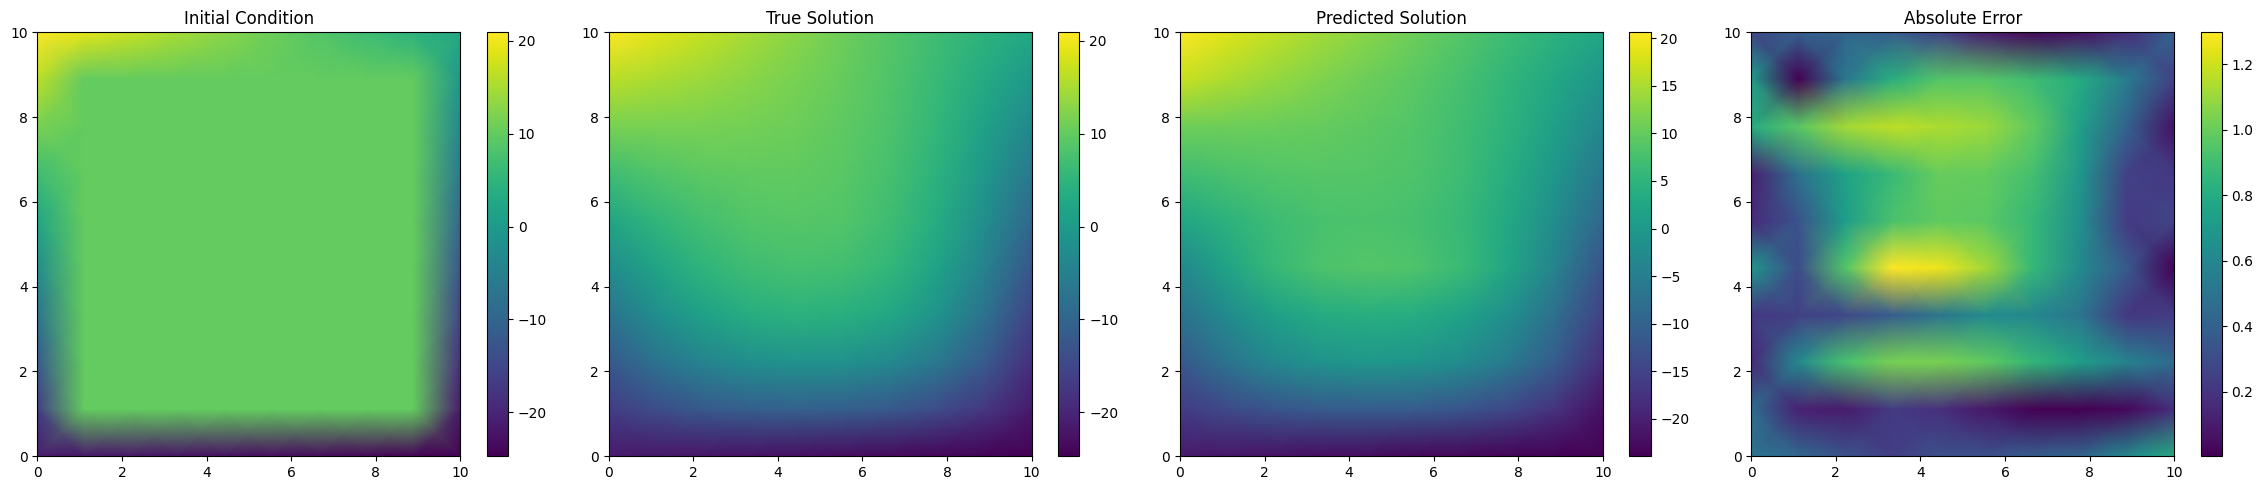

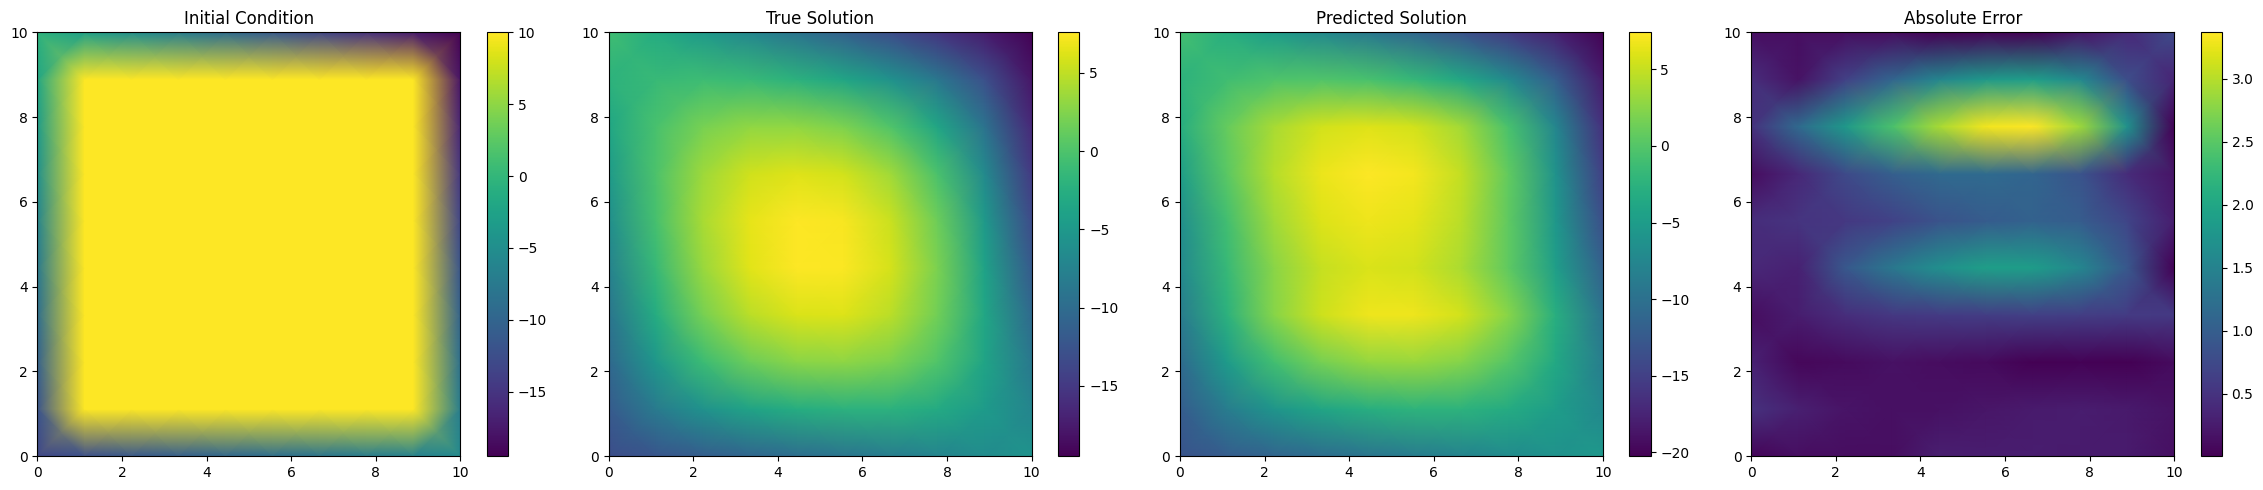

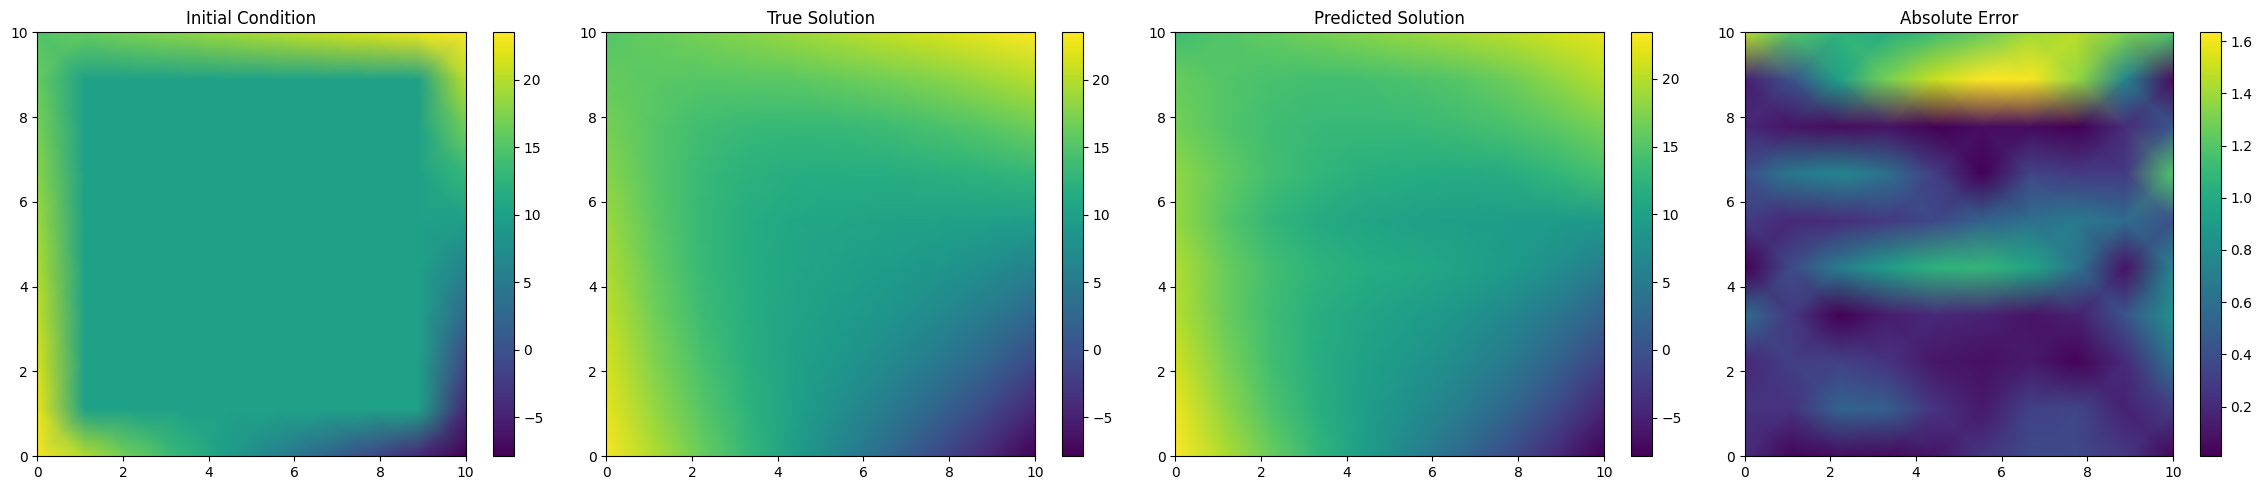

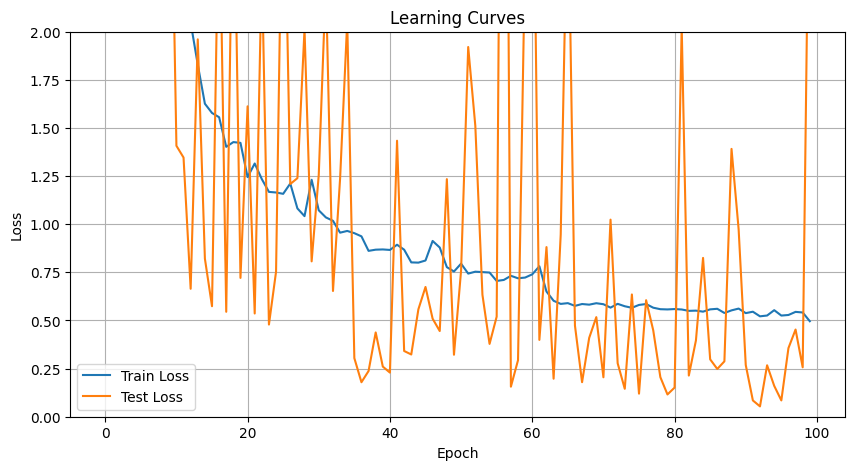

In [ ]:
train_losses_dataframe, test_losses_dataframe = main_smooth()

In [ ]:
train_losses_dataframe

,Epoch,Loss
0,0,83.191646
1,10,2.536713
2,20,1.244828
3,30,1.072387
4,40,0.866407
5,50,0.795155
6,60,0.739667
7,70,0.584440
8,80,0.559275
9,90,0.538164


In [ ]:
test_losses_dataframe

,Epoch,Loss
0,0,73.319000
1,10,1.407479
2,20,1.612512
3,30,1.256115
4,40,0.229214
5,50,0.759627
6,60,3.495698
7,70,0.204879
8,80,0.151378
9,90,0.268534


In [ ]:
print(train_losses_dataframe.to_latex(index=False,
                                      caption="Heat Equation Losses",
                                      position="htbp",
                                      column_format="|l|l|",
                                      escape=False,
                                      )
)

\begin{table}[htbp]
\caption{Heat Equation Losses}
\begin{tabular}{|l|l|}
\toprule
Epoch & Loss \\
\midrule
0 & 83.191646 \\
10 & 2.536713 \\
20 & 1.244828 \\
30 & 1.072387 \\
40 & 0.866407 \\
50 & 0.795155 \\
60 & 0.739667 \\
70 & 0.584440 \\
80 & 0.559275 \\
90 & 0.538164 \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
print(test_losses_dataframe.to_latex(index=False,
                                     caption="Heat Equation Losses",
                                     position="htbp",
                                     column_format="|l|l|",
                                     escape=False,
                                      )
)

\begin{table}[htbp]
\caption{Heat Equation Losses}
\begin{tabular}{|l|l|}
\toprule
Epoch & Loss \\
\midrule
0 & 73.319000 \\
10 & 1.407479 \\
20 & 1.612512 \\
30 & 1.256115 \\
40 & 0.229214 \\
50 & 0.759627 \\
60 & 3.495698 \\
70 & 0.204879 \\
80 & 0.151378 \\
90 & 0.268534 \\
\bottomrule
\end{tabular}
\end{table}

